In [ ]:
"""
Burada kendi Google Drive'ımızı bağlıyoruz.
"""

from google.colab import drive
drive.mount('/content/drive')

## Gerekli kütüphanelerin import edilmesi


In [ ]:
"""
Gerekli kütüphaneleri ekliyoruz.
Normalde bizden iki ayrı notebook isteniyor bunlardan biri preprocessing yapılan ve biride şu an okuduğunuz training için kullanılan.
Ancak, biz datasetleri driveda sakladığımız için preprocessing kısmında yapılan bazı adımları burada tekrar yapmak durumundayız çünkü oluşturulan listeler
ve data frameler notebook kapatıldığı zaman siliniyor.
"""

import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os 
from sklearn.model_selection import train_test_split
import cv2 as cv
from sklearn.preprocessing import LabelEncoder

## Dataset


In [ ]:
"""
'include' adında oluşturulan dictionary elimizdeki datasette yer alan classların numaralarını barındırıyor ve bunları aşağıda yer alan for
döngüsünde görüntüleri her klasörden doğru şekilde okuyup oluşturduğumuz boş listelere resimlerin pixel değerlerini ve onlara karşılık gelen
etiketleri listeye eklemek için kullanıyoruz.
"""

goruntu = []
etiket = []

include = {'0', '1', '2', '3', '4', '5', '6', '7', '8', '9'}

In [ ]:
"""
Buradaki for döngüsü iki ayrı adımdan oluşmakta. Birinci adımda 'os.listdir' fonksiyonunu kullanarak driveımdaki 'dataset' klasörü içersinde
bulunan klasörlerin adlarını alıyoruz bunlar yukarıdaki includeda yer alan sayılar. Yani birinci for döngüsü bir kere döndüğünde subdir=0 oluyor örnek olarak.
Ardından subdirin eşit olduğu değerin include içerisinde olup olmadığına bakıyoruz sonrasında 'os.path.join' fonksiyonu ile subdir'i ana path'e ekliyoruz.
Bu ana path class'ı farketmeksizin her resim için aynı. 
Örneğin 0. class'a ait bir resim için '/content/drive/MyDrive/Colab_Notebooks/Global_AI_Hub/dataset/0/RESİM_ADI'
1. class'a ait ise                    '/content/drive/MyDrive/Colab_Notebooks/Global_AI_Hub/dataset/1/RESİM_ADI'
2. class'a ait ise                    '/content/drive/MyDrive/Colab_Notebooks/Global_AI_Hub/dataset/2/RESİM_ADI'
.                                      .
.                                      .
.                                      .

ikinci for döngüsünde ise elimizdeki yolu kullanarak imread ile resmi okuyoruz ve pixel değerlerini 'goruntu' listesine ekliyoruz ve aynı şekilde etiketide 'etiket' listesine ekliyoruz.
"""

for subdir in os.listdir('/content/drive/MyDrive/Colab_Notebooks/Global_AI_Hub/dataset/'):
        if subdir in include:
            current_path = os.path.join('/content/drive/MyDrive/Colab_Notebooks/Global_AI_Hub/dataset/', subdir)
            for file in os.listdir(current_path):
              image = cv.imread(f"{os.path.join(current_path, file)}", cv.IMREAD_GRAYSCALE)
              goruntu.append(image)
              etiket.append(subdir)

In [ ]:
"""
Listeye eklenen etiketler bizim gözümüzde ne kadar sayı olsada append edilirken string olarak ekleniyor
normalde bu kodu ilk çalıştırdığınız zaman bu hücrenin çıktısının 'str' olması lazım. Oluşturulan model de etiket girdisi olarak
string kabul etmediğinden bütün etiketleri uygun olan int formatına dönüştürüyoruz
"""

type(etiket[0])

int

In [ ]:
"""
etiketler int oluyor
"""

etiket = [int(i) for i in etiket]

In [ ]:
"""
6. satırda datanın %10'u ile test setini oluşyuruyoruz burada x_main ve y_main içerlerinde train ve validation setlerini beraber barındırıyor.
7. satırda ise tekrardan bir split yapıp bu ikisini birbirinden ayırıyoruz ve datamız 80 10 10 şeklinde train,validation ve test olarak ayrılıyor.
"""

x_main, x_test, y_main, y_test = train_test_split(goruntu, etiket, test_size = 0.1, random_state = 42, stratify = etiket)
x_train, x_val, y_train, y_val = train_test_split(x_main, y_main, test_size = 0.1, random_state = 42, stratify = y_main)

In [ ]:
"""
kontrol amaçlı sayılarına bakıyoruz.
"""

print(f"x_train: {len(x_train)}")
print(f"x_test: {len(x_test)}")

x_train: 7072
x_test: 874


## Modelin oluşturulması


In [ ]:
"""
Modelin oluşturulması.
"""

model = tf.keras.Sequential()

### Feature extraction katmanları



In [ ]:
"""
Burada input_shape resimleri 256,256 olarak resize ettiğimiz için ve grayscale dönüşümü yaptığımız için 256,256,1 şeklinde
"""

model.add(tf.keras.layers.Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', input_shape=(256,256,1)))
model.add(tf.keras.layers.MaxPooling2D((2,2)))

In [ ]:
model.add(tf.keras.layers.Conv2D(64,
                                 kernel_size=(3,3),
                                 strides=(1,1),
                                 padding="same",
                                 activation="relu"))
model.add(tf.keras.layers.MaxPooling2D((2,2)))
model.add(tf.keras.layers.Conv2D(64,
                                 kernel_size=(3,3),
                                 strides=(1,1),
                                 padding="same",
                                 activation="relu"))

### Flatten



In [ ]:
model.add(tf.keras.layers.Flatten())

### Classification katmanları



In [ ]:
model.add(tf.keras.layers.Dense(64, activation="relu"))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(64, activation="relu"))
model.add(tf.keras.layers.Dropout(0.5))

### Output katmanları


In [ ]:
"""
10 sınıfımız olduğu için çıkış katmanındaki nöron sayısı 10
"""

model.add(tf.keras.layers.Dense(10, activation="softmax"))

### Optimizer



In [ ]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

## Modelin eğitilmesi


In [ ]:
"""
sisteme girdileri vermeden np.array ile girdileri uygun format olan numpy array haline getiriyoruz.
"""

results = model.fit(np.array(x_train), np.array(y_train),
                    batch_size=4,
                    epochs=50,
                    validation_data=(np.array(x_val), np.array(y_val)))

Epoch 1/50
1768/1768 [==============================] - 37s 13ms/step - loss: 1.9676 - accuracy: 0.2872 - val_loss: 1.4790 - val_accuracy: 0.4975
Epoch 2/50
1768/1768 [==============================] - 23s 13ms/step - loss: 1.5392 - accuracy: 0.4525 - val_loss: 1.1968 - val_accuracy: 0.5852
Epoch 3/50
1768/1768 [==============================] - 23s 13ms/step - loss: 1.2733 - accuracy: 0.5535 - val_loss: 1.0908 - val_accuracy: 0.6578
Epoch 4/50
1768/1768 [==============================] - 22s 13ms/step - loss: 1.0978 - accuracy: 0.6267 - val_loss: 1.0971 - val_accuracy: 0.6565
Epoch 5/50
1768/1768 [==============================] - 22s 12ms/step - loss: 0.9399 - accuracy: 0.6841 - val_loss: 1.1253 - val_accuracy: 0.6718
Epoch 6/50
1768/1768 [==============================] - 22s 12ms/step - loss: 0.8393 - accuracy: 0.7264 - val_loss: 1.1768 - val_accuracy: 0.6527
Epoch 7/50
1768/1768 [==============================] - 22s 13ms/step - loss: 0.7705 - accuracy: 0.7445 - val_loss: 1.2384 -

### Sonuçların görselleştirilmesi

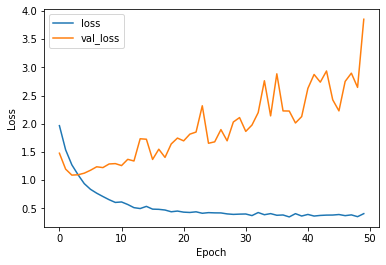

In [ ]:
"""
Sonuçların çizilmesi.
"""

plt.plot(results.history["loss"], label="loss")

plt.plot(results.history["val_loss"], label="val_loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.legend()

plt.show()

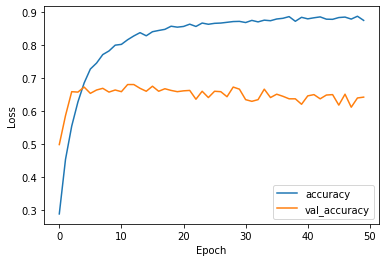

In [ ]:
"""
Sonuçların çizilmesi.
"""

plt.plot(results.history["accuracy"], label="accuracy")

plt.plot(results.history["val_accuracy"], label="val_accuracy")

plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.legend()

plt.show()

## Performans değerlendirmesi

In [ ]:
"""
Girdiyi yine sisteme vermeden önce array yapıyoruz.
"""

model.evaluate(np.array(x_test), np.array(y_test))

28/28 [==============================] - 1s 29ms/step - loss: 3.1258 - accuracy: 0.6419


[3.12577486038208, 0.6418764591217041]

### Modele tahmin ettirme

In [ ]:
"""
Girdiyi yine sisteme vermeden önce array yapıyoruz.
"""

prediction_result = model.predict(np.array(x_test[111]).reshape(1,256,256,1))

prediction_result

array([[9.6162236e-01, 2.4248677e-06, 2.2584098e-05, 3.0441055e-10,
        2.4588254e-09, 3.8328137e-02, 0.0000000e+00, 2.4503750e-05,
        2.4590399e-10, 7.2752959e-09]], dtype=float32)

### Ait olunan sınıfın ve o sınıfa ait olma olasılığının bulunması

In [ ]:
"""
Tahmin sonucu.
"""

predicted_class = prediction_result.argmax()
predicted_probability = prediction_result.max()

In [ ]:
print(f"This image belongs to class {predicted_class} with {predicted_probability} probability %")

This image belongs to class 0 with 0.9616223573684692 probability %
